### 주제: 건설 장비 내부 기계 부품의 마모 상태 및 윤활 성능을 오일 데이터 분석을 통해 확인하고, AI를 활용한 분류 모델 개발을 통해 적절한 교체 주기를 파악

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV


데이터 분석 목표: 샘플 오일 관련 부품 정보를 분석해 오일 정상 여부 예측

In [141]:
train = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/train.csv')
test_df = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/test.csv')
submission = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/sample_submission.csv')

In [142]:
test_df.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

In [143]:
columns = ['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN','Y_LABEL']

변수 정보   
ANONYMOUS_1 - 무명 Feature 1. 수치형 데이터   
ANONYMOUS_2 - 무명 Feature 2. 수치형 데이터   
AG, CO, CR, FE, H2O, MN, MO, NI, TI, V, ZN - 원소기호   
V40 - 40도에서 측정한 액체의 점도   
YEAR - 오일샘플 및 진단 해(Year)    
PQINDEX(Particle Quantifier Index) : Particle Quantifier Index(PQ Index), 또는 PQI라고도 불리는 이 지표는 입자의 크기와 상관없이 윤활유 샘플 내에 존재하는 전체 강자성 물질(자성을 띤 금속 입자)의 양을 측정하는 방법이다.
이 지표는 마모로 인한 문제가 발생할 가능성을 조기에 감지하기 위한 선별 검사 도구로 사용되며, 예지 보전(predictive maintenance) 프로그램에서 자주 활용된다.    

Y_LABEL - 타깃변수로 0일 때 정상, 1일 때 비정상


train 데이터에는 존재하나 test 데이터에는 없는 변수들 존재했었다. 이는 모델 학습 시 사용할 수 없는 변수들이기 때문에 제거해주었다.    

In [144]:
train_df = train[columns]

In [145]:
train_df['COMPONENT_ARBITRARY'].value_counts()

COMPONENT_ARBITRARY
COMPONENT3    7050
COMPONENT1    3890
COMPONENT2    2316
COMPONENT4     839
Name: count, dtype: int64

부품 종류로는 4개가 있으며 1은 3890개, 2는 2316개, 3은 7050개, 4는 839개씩 있다.    

In [146]:
# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 개수
count = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)


개수:
 Y_LABEL                 0     1
COMPONENT_ARBITRARY            
COMPONENT1           3500   390
COMPONENT2           1915   401
COMPONENT3           4906  2144
COMPONENT4            750    89

비율:
 Y_LABEL                     0         1
COMPONENT_ARBITRARY                    
COMPONENT1           0.899743  0.100257
COMPONENT2           0.826857  0.173143
COMPONENT3           0.695887  0.304113
COMPONENT4           0.893921  0.106079


COMPONENT_ARBITRARY별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 COMPONENT 2와 3에서 이상 오일 비율이 높게 나온 것을 확인할 수 있었다.    
이상 샘플이 Component 3에서 차지하는 비율이 0.3으로 다른 Component에 비해 높게 나온 것을 확인

In [147]:
# YEAR별 Y_LABEL의 0,1 개수
count = train_df.groupby('YEAR')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# YEAR별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('YEAR')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)

개수:
 Y_LABEL     0    1
YEAR              
2007      236   92
2008     1062  357
2009      681  268
2010      639  227
2011      910  236
2012      849  224
2013      949  240
2014     1133  267
2015      935  221
2016      771  171
2017      740  156
2018      699  179
2019      520  129
2020      275   98
2021      381   96
2022      291   63

비율:
 Y_LABEL         0         1
YEAR                       
2007     0.719512  0.280488
2008     0.748414  0.251586
2009     0.717597  0.282403
2010     0.737875  0.262125
2011     0.794066  0.205934
2012     0.791240  0.208760
2013     0.798150  0.201850
2014     0.809286  0.190714
2015     0.808824  0.191176
2016     0.818471  0.181529
2017     0.825893  0.174107
2018     0.796128  0.203872
2019     0.801233  0.198767
2020     0.737265  0.262735
2021     0.798742  0.201258
2022     0.822034  0.177966


YEAR별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 특정 연도에서 비정상 비율이 높게 나온 것을 확인할 수 있었다

In [148]:
train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)

# 평균값을 표로 보기 좋게 출력
mean_df = train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)
display(mean_df)

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
COMPONENT_ARBITRARY,,,,,,,,,,,,,,,,,,
COMPONENT1,-0.986054,2013.729563,-0.959173,0.025193,0.014396,1.910540,9.929563,27.057069,0.002699,0.514910,69.364267,0.152185,20.422622,0.055013,0.024422,102.678103,1161.010283,0.100257
COMPONENT2,-0.986206,2013.718912,-0.961256,0.024180,0.009499,0.515976,56.677029,18.890328,0.003282,0.155872,0.652418,0.027634,27.230570,0.032815,0.010794,52.720695,505.785838,0.173143
COMPONENT3,-0.984818,2013.494043,-0.961531,0.028227,0.044397,5.361986,32.252057,332.500426,0.064525,5.137163,3.415745,1.362553,807.300567,1.372908,0.082837,136.411370,241.379574,0.304113
COMPONENT4,-0.984588,2014.443385,-0.953130,0.013111,0.007151,0.091776,107.109654,21.651967,0.001549,0.852205,50.958284,0.034565,21.091776,0.010727,0.011919,69.310012,1081.669845,0.106079


ANONYMOUS_1 과 ANONYMOUS_2는 더해서 하나의 변수로 만들어주었다.

In [149]:
# ANONYMOUS_1 과 ANONYMOUS_2 더해서 새로운 피처 생성
train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']

# ANONYMOUS_1, ANONYMOUS_2 제거
train_df = train_df.drop(columns=['ANONYMOUS_1', 'ANONYMOUS_2'])

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_14992\1612360360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']


In [150]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats = train_df.groupby(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']).median(numeric_only=True)
grouped_stats

AG   CO   CR    CU    FE  H2O   MN     MO  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                               
COMPONENT1          2007 0        0.0  0.0  2.0   3.0  23.5  0.0  1.0   21.0   
                         1        0.0  0.0  3.0  22.0  47.0  0.0  1.0  104.0   
                    2008 0        0.0  0.0  1.0   4.0  21.0  0.0  1.0   37.0   
                         1        0.0  0.0  4.0   9.0  51.5  0.0  1.0   99.0   
                    2009 0        0.0  0.0  2.0   4.0  24.0  0.0  1.0   37.0   
...                               ...  ...  ...   ...   ...  ...  ...    ...   
COMPONENT4          2020 1        0.0  0.0  0.0  17.5  44.0  0.0  1.5   22.0   
                    2021 0        0.0  0.0  0.0   0.0  11.0  0.0  0.0    2.0   
                         1        0.0  0.0  0.0   5.5  54.5  0.0  0.0    5.5   
                    2022 0        0.0  0.0  0.0   1.0  11.0  0.0  0.0   20.0   
                         1        0.0  0.0  0.0   1.0  11.0  0.0  0.0   25.0   

                                   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                           
COMPONENT1          2007 0        0.0     17.0  0.0  0.0  101.30  1208.5   
                         1        0.0     18.0  0.0  0.0  112.60  1280.0   
                    2008 0        0.0     14.0  0.0  0.0  105.30  1225.0   
                         1        1.0     17.0  0.0  0.0  109.25  1278.0   
                    2009 0        0.0     12.0  0.0  0.0  103.20  1183.0   
...                               ...      ...  ...  ...     ...     ...   
COMPONENT4          2020 1        0.0     48.0  0.0  0.0   53.35   480.5   
                    2021 0        0.0     11.0  0.0  0.0   71.40  1038.0   
                         1        0.0     25.0  0.0  0.0   64.00  1109.0   
                    2022 0        0.0      8.0  0.0  0.0   70.40  1077.0   
                         1        0.0     10.0  0.0  0.0   59.80  1162.0   

                                  ANONYMOUS_SUM  
COMPONENT_ARBITRARY YEAR Y_LABEL                 
COMPONENT1          2007 0            -1.953617  
                         1            -1.960353  
                    2008 0            -1.958369  
                         1            -1.928166  
                    2009 0            -1.988598  
...                                         ...  
COMPONENT4          2020 1            -1.958085  
                    2021 0            -1.904710  
                         1            -1.977001  
                    2022 0            -1.912576  
                         1            -1.894914  

[127 rows x 15 columns]

In [151]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats2 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).mean(numeric_only=True)
grouped_stats2

YEAR        AG        CO         CR  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        2013.795429  0.023143  0.014571   1.378000   
                    1        2013.138462  0.043590  0.012821   6.689744   
COMPONENT2          0        2013.817755  0.025587  0.007833   0.401044   
                    1        2013.246883  0.017456  0.017456   1.064838   
COMPONENT3          0        2013.614757  0.024868  0.023848   1.779250   
                    1        2013.217817  0.035914  0.091418  13.560168   
COMPONENT4          0        2014.441333  0.013333  0.004000   0.076000   
                    1        2014.460674  0.011236  0.033708   0.224719   

                                     CU          FE       H2O         MN  \
COMPONENT_ARBITRARY Y_LABEL                                                
COMPONENT1          0          8.921714   22.762571  0.001571   0.450571   
                    1         18.974359   65.597436  0.012821   1.092308   
COMPONENT2          0         52.925849   13.013055  0.001097   0.096606   
                    1         74.591022   46.957606  0.013716   0.438903   
COMPONENT3          0         19.878516  156.025275  0.004260   2.804525   
                    1         60.565765  736.319030  0.202425  10.474813   
COMPONENT4          0        107.133333   19.585333  0.001200   0.644000   
                    1        106.910112   39.067416  0.004494   2.606742   

                                    MO        NI      PQINDEX        TI  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        69.089429  0.102286    12.703143  0.020571   
                    1        71.830769  0.600000    89.700000  0.364103   
COMPONENT2          0         0.572324  0.023499    13.025065  0.021932   
                    1         1.034913  0.047382    95.069825  0.084788   
COMPONENT3          0         2.704240  0.622503   316.359967  0.135956   
                    1         5.043843  3.055970  1930.693563  4.203358   
COMPONENT4          0        52.713333  0.034667    16.044000  0.009333   
                    1        36.168539  0.033708    63.629213  0.022472   

                                    V         V40           ZN  ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                                                    
COMPONENT1          0        0.021429  102.497291  1160.656571      -1.945416  
                    1        0.051282  104.300769  1164.184615      -1.943537  
COMPONENT2          0        0.012533   52.290501   518.969191      -1.946706  
                    1        0.002494   54.775112   442.827930      -1.951072  
COMPONENT3          0        0.023848  134.057440   260.599674      -1.946695  
                    1        0.217817  141.797743   197.399254      -1.945556  
COMPONENT4          0        0.013333   69.785867  1096.238667      -1.938453  
                    1        0.000000   65.300000   958.898876      -1.931529

In [152]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats3 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).median(numeric_only=True)
grouped_stats3

YEAR   AG   CO   CR    CU     FE  H2O   MN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        2014.0  0.0  0.0  1.0   3.0   18.0  0.0  0.0   
                    1        2013.0  0.0  0.0  3.0   7.0   43.5  0.0  1.0   
COMPONENT2          0        2014.0  0.0  0.0  0.0  11.0    5.0  0.0  0.0   
                    1        2013.0  0.0  0.0  0.0  21.0   14.0  0.0  0.0   
COMPONENT3          0        2014.0  0.0  0.0  1.0   4.0   96.0  0.0  1.0   
                    1        2013.0  0.0  0.0  4.0   5.0  379.0  0.0  5.0   
COMPONENT4          0        2014.0  0.0  0.0  0.0   5.0   16.0  0.0  0.0   
                    1        2014.0  0.0  0.0  0.0  21.0   23.0  0.0  0.0   

                               MO   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        20.0  0.0     11.0  0.0  0.0  100.50  1148.0   
                    1        34.0  0.0     17.0  0.0  0.0  102.95  1170.5   
COMPONENT2          0         0.0  0.0     11.0  0.0  0.0   47.10   566.0   
                    1         0.0  0.0     30.0  0.0  0.0   53.00   445.0   
COMPONENT3          0         0.0  0.0    106.0  0.0  0.0  136.50    38.0   
                    1         1.0  1.0    744.0  0.0  0.0  138.40    38.0   
COMPONENT4          0        10.5  0.0     15.0  0.0  0.0   70.65  1131.0   
                    1         8.0  0.0     25.0  0.0  0.0   68.20  1107.0   

                             ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                 
COMPONENT1          0            -1.979308  
                    1            -1.978154  
COMPONENT2          0            -1.978818  
                    1            -1.982075  
COMPONENT3          0            -1.976357  
                    1            -1.975860  
COMPONENT4          0            -1.977908  
                    1            -1.972581

변수들간의 수치를 직접 비교하기 위해서 스케일링을 적용시켰다

In [153]:
# 스케일링 대상 수치형 변수 리스트 (ID, COMPONENT_ARBITRARY, Y_LABEL 제외)
num_cols = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL', 'YEAR']]

scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[num_cols] = scaler.fit_transform(train_df[num_cols])

display(train_df_scaled.head())

,ID,COMPONENT_ARBITRARY,YEAR,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL,ANONYMOUS_SUM
0,TRAIN_00000,COMPONENT3,2011,-0.150214,-0.089633,0.339245,0.336858,1.331290,-0.041588,1.186914,-0.384284,1.384414,5.293270,0.622282,-0.10655,0.899892,-0.966002,1,-0.418234
1,TRAIN_00001,COMPONENT2,2021,-0.150214,-0.089633,-0.115388,-0.027612,-0.330406,-0.041588,-0.250456,-0.400998,-0.191804,-0.259244,-0.102635,-0.10655,-1.317376,0.119147,0,-0.121986
2,TRAIN_00002,COMPONENT2,2015,-0.150214,-0.089633,-0.080416,-0.252497,-0.326655,-0.041588,-0.250456,-0.400998,-0.191804,-0.260552,-0.102635,-0.10655,-0.740886,-0.332215,0,-0.366290
3,TRAIN_00003,COMPONENT3,2010,-0.150214,-0.089633,-0.115388,-0.260252,-0.264764,-0.041588,-0.160621,-0.400998,-0.191804,-0.242884,-0.102635,-0.10655,0.482642,-1.093888,0,-0.088173
4,TRAIN_00004,COMPONENT3,2015,-0.150214,-0.089633,-0.115388,-0.268007,-0.200996,-0.041588,-0.250456,-0.400998,-0.191804,-0.129674,-0.102635,-0.10655,0.478611,-0.866326,0,-0.280238


## Optuna 튜닝용 모델 학습 함수

In [154]:
# Optuna 튜닝용 objective 함수 예시 (각 모델별)

# random forest
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# gradient boosting
def gb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# lightgbm
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# extra trees
def extratrees_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# catboost
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# adaboost
def adaboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'random_state': 42
    }
    model = AdaBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# xgboost
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

In [199]:
def optuna_model_train_eval(objective_func, model_class, X_train, X_test, y_train, y_test, n_trials=50, random_state=42, model_name="Model"):
    # Optuna 스터디 생성 및 최적화 실행
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)

    print(f"Best parameters ({model_name}):", study.best_params)
    print(f"Best F1 score (CV, {model_name}):", study.best_value)

    # 최적 파라미터로 모델 학습 및 테스트셋 평가
    best_model = model_class(**study.best_params, random_state=random_state)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"Test Accuracy ({model_name}): {acc:.4f}")
    print(f"Test F1 Score ({model_name}): {f1:.4f}")
    print(f"Test ROC AUC ({model_name}): {auc:.4f}")

    return best_model, study

## Component 1

In [155]:
comp_1 = train_df_scaled[train_df_scaled['COMPONENT_ARBITRARY'] == 'COMPONENT1']

In [156]:
# Y_LABEL이 0과 1인 데이터 각각 추출
comp1_0 = comp_1[comp_1['Y_LABEL'] == 0]
comp1_1 = comp_1[comp_1['Y_LABEL'] == 1]

# 주요 변수별 평균 비교
mean_0 = comp1_0.mean(numeric_only=True)
mean_1 = comp1_1.mean(numeric_only=True)
diff = pd.DataFrame({'Y_LABEL=0': mean_0, 'Y_LABEL=1': mean_1})

display(diff)

# 주요 변수별 중앙값 비교
median_0 = comp1_0.median(numeric_only=True)
median_1 = comp1_1.median(numeric_only=True)
median_diff = pd.DataFrame({'Y_LABEL=0': median_0, 'Y_LABEL=1': median_1})

display(median_diff)

,Y_LABEL=0,Y_LABEL=1
YEAR,2013.795429,2013.138462
AG,-0.015600,0.103333
CO,-0.043262,-0.048834
CR,-0.067197,0.118564
CU,-0.198822,-0.120867
FE,-0.291466,-0.211129
H2O,-0.039646,-0.025743
MN,-0.209979,-0.152328
MO,0.753730,0.799547
NI,-0.164933,-0.034182


,Y_LABEL=0,Y_LABEL=1
YEAR,2014.000000,2013.000000
AG,-0.150214,-0.150214
CO,-0.089633,-0.089633
CR,-0.080416,-0.010473
CU,-0.244743,-0.213724
FE,-0.300398,-0.252573
H2O,-0.041588,-0.041588
MN,-0.250456,-0.160621
MO,-0.066727,0.167262
NI,-0.191804,-0.191804


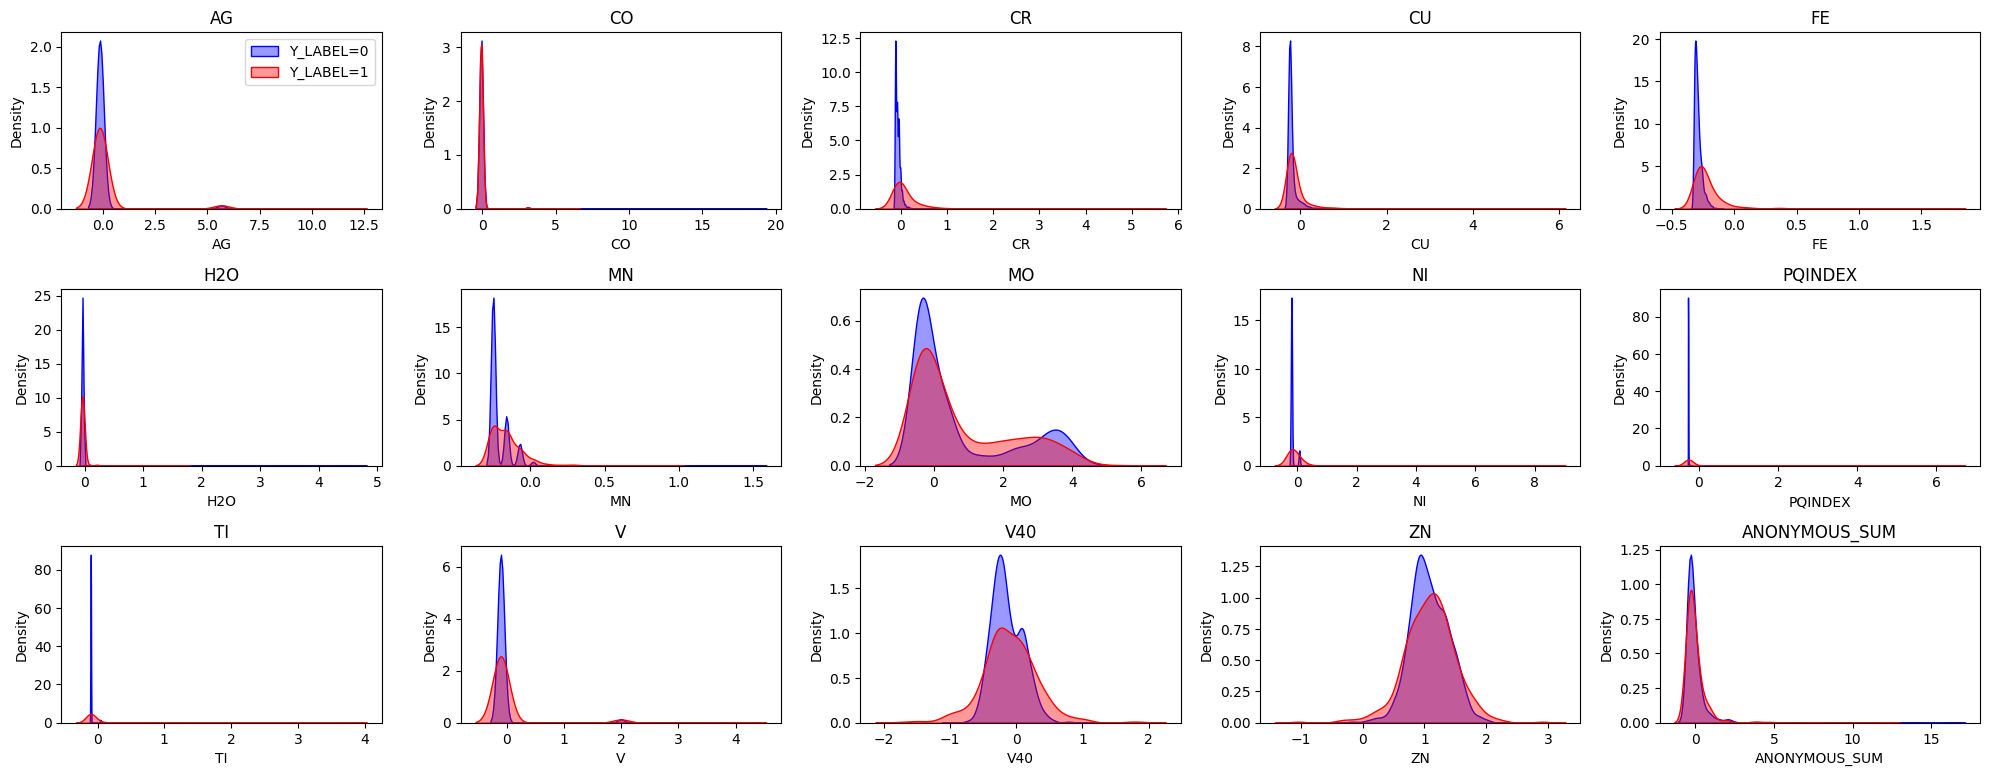

In [157]:
plt.figure(figsize=(20, 10))
for var in num_cols:
  plt.subplot(4, 5, num_cols.index(var)+1)
  sns.kdeplot(comp1_0[var], label='Y_LABEL=0', color='blue', fill=True, alpha=0.4)
  sns.kdeplot(comp1_1[var], label='Y_LABEL=1', color='red', fill=True, alpha=0.4)
  plt.title(var)
  plt.xlabel(var)
  plt.ylabel('Density')
  if num_cols.index(var) == 0:
    plt.legend()
plt.tight_layout()
plt.show()

In [158]:
# 주요 변수별 첨도(kurtosis)와 왜도(skewness) 계산
# independent_vars 정의 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in train_df_scaled.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL']]

kurt_skew = []
for col in independent_vars:
  kurt_0 = kurtosis(comp1_0[col], nan_policy='omit')
  skew_0 = skew(comp1_0[col], nan_policy='omit')
  kurt_1 = kurtosis(comp1_1[col], nan_policy='omit')
  skew_1 = skew(comp1_1[col], nan_policy='omit')
  kurt_skew.append({
    '변수': col,
    'Y_LABEL=0_첨도': kurt_0,
    'Y_LABEL=0_왜도': skew_0,
    'Y_LABEL=1_첨도': kurt_1,
    'Y_LABEL=1_왜도': skew_1
  })

kurt_skew_df = pd.DataFrame(kurt_skew)
display(kurt_skew_df)

,변수,Y_LABEL=0_첨도,Y_LABEL=0_왜도,Y_LABEL=1_첨도,Y_LABEL=1_왜도
0,YEAR,-0.813341,0.203178,-0.778083,0.315697
1,AG,67.150865,7.801908,28.821065,5.209102
2,CO,530.084882,21.091363,146.515223,11.603144
3,CR,56.286637,4.844041,54.296022,6.469251
4,CU,156.793762,10.042461,182.137760,11.720187
5,FE,3.578405,1.647011,57.675075,6.375339
6,H2O,3413.980048,58.125377,124.521614,10.652073
7,MN,88.853564,5.352258,16.734030,3.147165
8,MO,-0.435580,1.087998,-0.408000,0.984233
9,NI,254.105542,10.783326,112.774594,9.741826


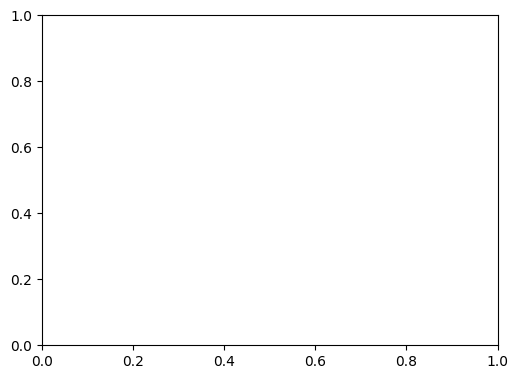

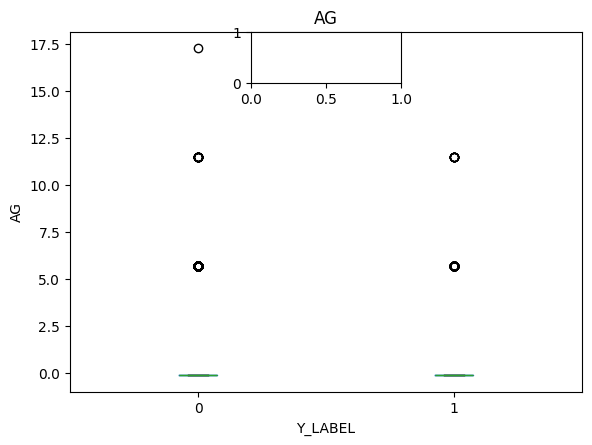

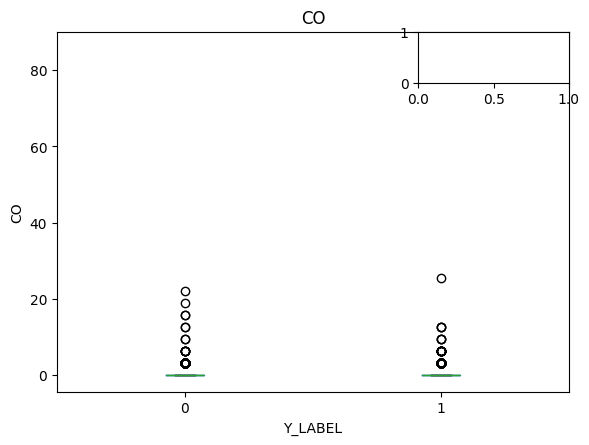

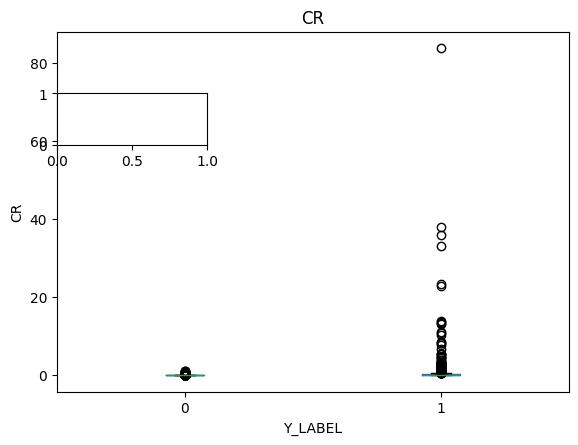

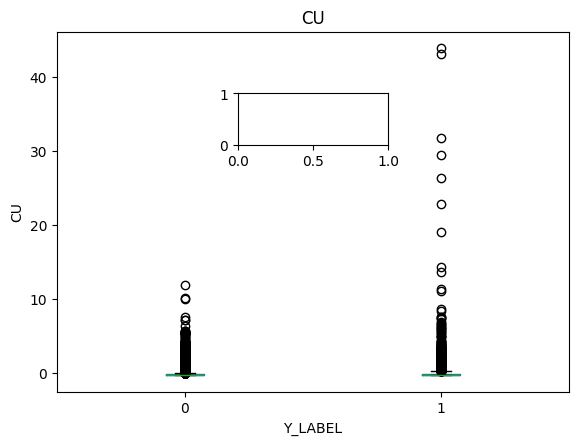

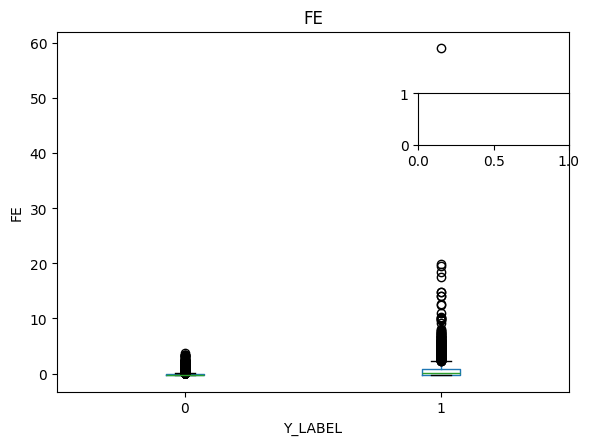

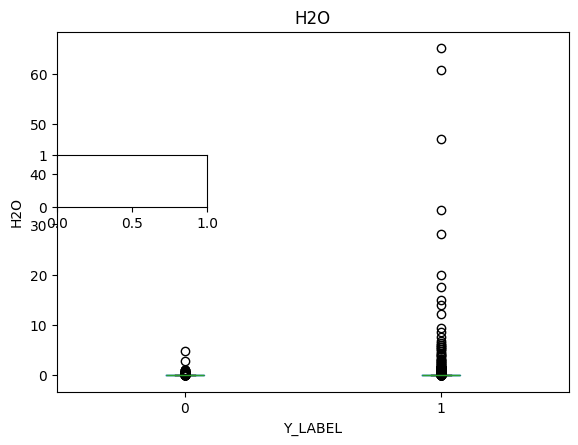

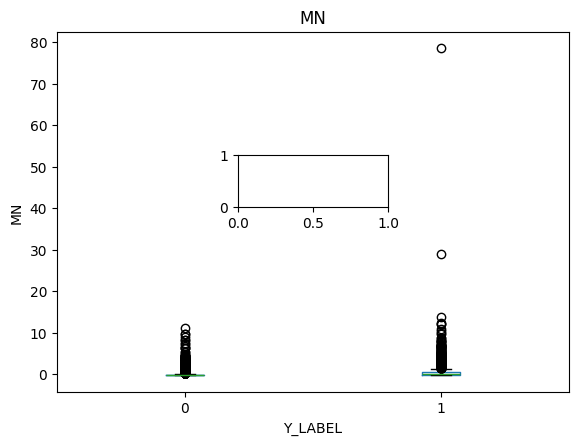

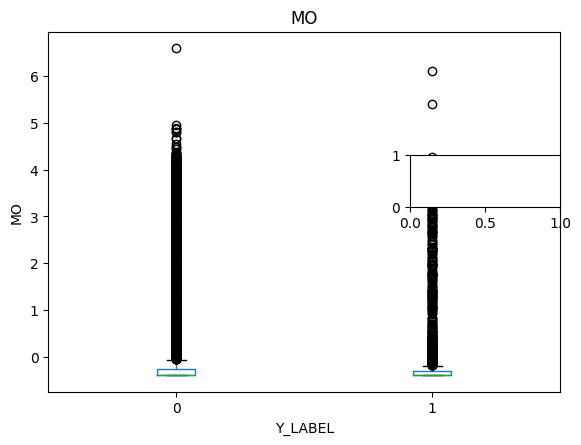

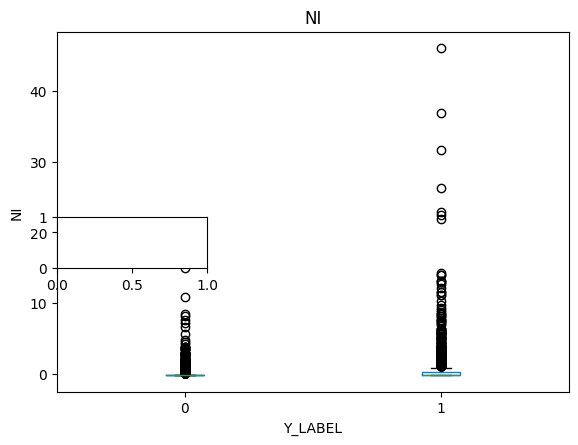

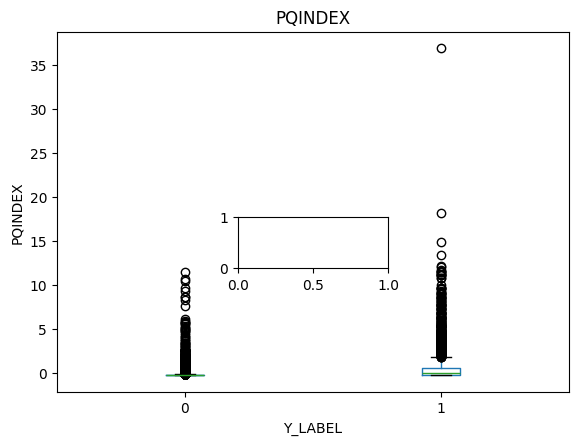

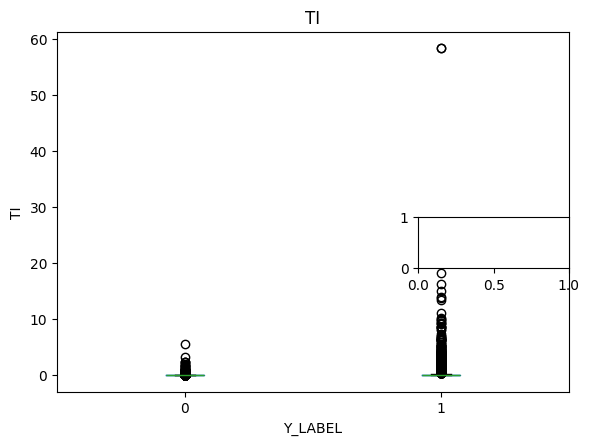

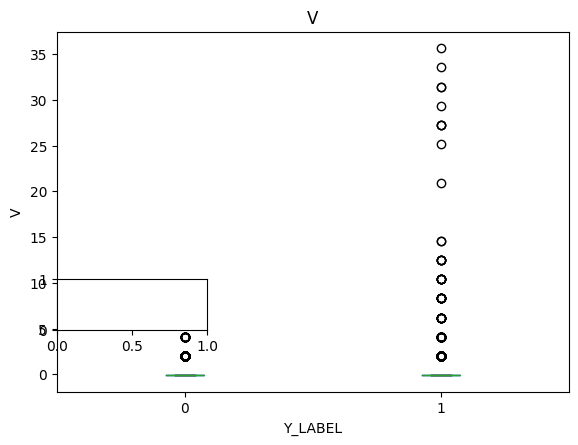

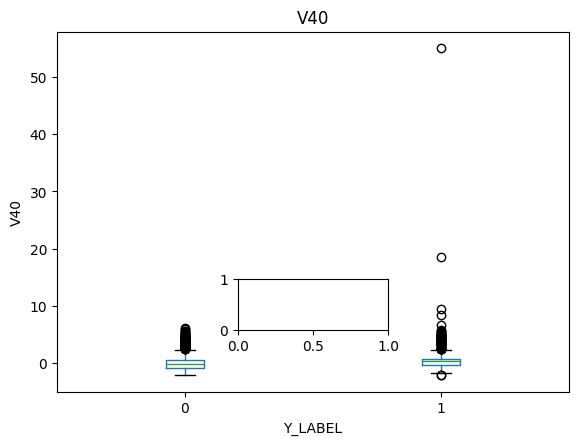

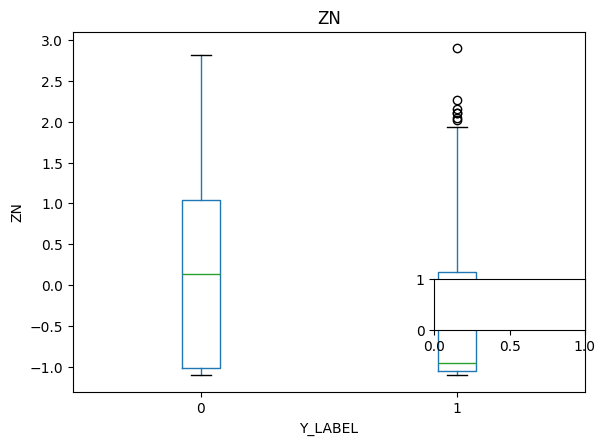

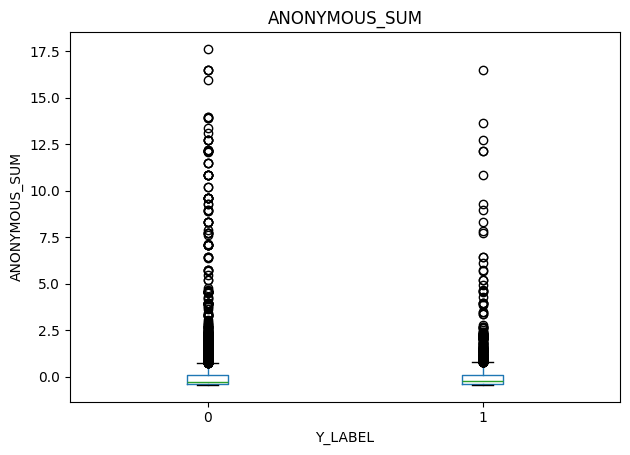

In [159]:
# 변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY, YEAR 제외)
plot_vars = [col for col in train_df_scaled.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR','Y_LABEL']]

plt.figure(figsize=(20, 30))
for i, var in enumerate(plot_vars):
  plt.subplot(6, 3, i+1)
  train_df_scaled.boxplot(column=var, by='Y_LABEL', grid=False)
  plt.title(var)
  plt.suptitle('')
  plt.xlabel('Y_LABEL')
  plt.ylabel(var)
plt.tight_layout()
plt.show()

In [ ]:
# COMPONENT1 데이터에서 독립변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in comp_1.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 결과 저장용
test_results = []

for col in independent_vars:
    # 두 그룹 데이터
    group0 = comp1_0[col]
    group1 = comp1_1[col]
    # 정규성, 등분산성 가정이 어려우므로 Mann-Whitney U test 사용
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    # p-value를 소수점 5자리까지만 표시
    p_rounded = round(p, 5)
    test_results.append({'변수': col, 'Mann-Whitney U 통계량': stat, 'p-value': p_rounded})

# 결과 DataFrame으로 정리
test = pd.DataFrame(test_results)
display(test.sort_values('p-value'))

,변수,Mann-Whitney U 통계량,p-value
2,CR,353065.5,0.00000
3,CU,443482.0,0.00000
4,FE,291486.0,0.00000
5,H2O,662813.5,0.00000
6,MN,469298.0,0.00000
8,NI,546839.0,0.00000
9,PQINDEX,403131.5,0.00000
10,TI,601926.5,0.00000
11,V,663652.5,0.00071
0,AG,668762.5,0.01169


유의미한 변수 (p-value ≤ 0.05)    
CR, CU, FE, H2O, MN, NI, PQINDEX, TI, V, AG, V40    
이 변수들은 정상/비정상 그룹 간 분포 차이가 유의하다.   
특히 CR, CU, FE, H2O, MN, NI, PQINDEX, TI는 p-value가 0에 가까워 차이가 매우 크다.    
V, AG, V40도 0.05 이하로 유의미하다.    

유의미하지 않은 변수 (p-value > 0.05)   
MO, ANONYMOUS_SUM, ZN, CO   
이 변수들은 정상/비정상 그룹 간 분포 차이가 통계적으로 유의하지 않다.   
즉, 이 변수들은 Y_LABEL 분류에 큰 영향을 주지 않을 수 있다.

In [ ]:
plt.figure(figsize=(14, 10))
corr = comp_1.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Component1 데이터 상관관계 히트맵")
plt.show()

### 모델링

In [161]:
# 범주형 변수는 원-핫 인코딩처리
comp1_df = pd.get_dummies(comp_1, columns=['YEAR'], prefix='YEAR')

In [162]:
# X, y 분리 (ID, COMPONENT_ARBITRARY, Y_LABEL은 제외)
X = comp1_df.drop(columns=['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL'])
y = comp1_df['Y_LABEL']

# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (3112, 31) (3112,)
Test shape: (778, 31) (778,)


In [163]:
# 여러 모델 정의
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=300, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=300, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=300, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=300, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=300, random_state=42, verbose=0)
}

results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

  results.append({
    'Model': name,
    'Accuracy': acc,
    'F1 Score': f1,
    'ROC AUC': auc
  })

results_df = pd.DataFrame(results)
display(results_df.sort_values('F1 Score', ascending=False))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 312, number of negative: 2800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 3112, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100257 -> initscore=-2.194372
[LightGBM] [Info] Start training from score -2.194372


,Model,Accuracy,F1 Score,ROC AUC
2,GradientBoosting,0.917738,0.507692,0.853608
7,CatBoost,0.924165,0.504202,0.885806
5,XGBoost,0.921594,0.504065,0.857161
1,RandomForest,0.925450,0.491228,0.877381
6,LightGBM,0.921594,0.478632,0.870293
4,AdaBoost,0.910026,0.416667,0.754359
3,ExtraTrees,0.921594,0.407767,0.864551
0,LogisticRegression,0.913882,0.294737,0.786410


Component1를 넣고 모델링을 했을 시에는 GradientBoosting의 성능이 가장 높게 나왔다. 상위 3개 모델을 기준으로 RFECV를 활용해 최적의 변수 조합을 찾고 Optuna를 활용해 하이퍼파라미터 튜닝을 진행하기로 했다

### 최적의 변수 조합 찾기

In [202]:
# GradientBoost 모델을 위한 RFECV (하이퍼파라미터 튜닝 전, 기본 파라미터 사용)
gb_estimator = GradientBoostingClassifier(n_estimators=300, random_state=42)
rfecv_gb = RFECV(gb_estimator, step=1, cv=5, scoring='f1', n_jobs=-1)
rfecv_gb.fit(X_train, y_train)

print("최적 변수 개수:", rfecv_gb.n_features_)
print("최적 변수 목록:", X_train.columns[rfecv_gb.support_].tolist())

# 변수별 ranking 출력
feature_ranking_gb = pd.DataFrame({
  'feature': X_train.columns,
  'ranking': rfecv_gb.ranking_,
  'selected': rfecv_gb.support_
}).sort_values('ranking')
display(feature_ranking_gb)

# 최적 변수만 사용해서 다시 모델 학습 및 평가
best_gb_sel = GradientBoostingClassifier(n_estimators=300, random_state=42)
best_gb_sel.fit(X_train[X_train.columns[rfecv_gb.support_]], y_train)
y_pred_gb_sel = best_gb_sel.predict(X_test[X_test.columns[rfecv_gb.support_]])
y_proba_gb_sel = best_gb_sel.predict_proba(X_test[X_test.columns[rfecv_gb.support_]])[:, 1]

acc_gb_sel = accuracy_score(y_test, y_pred_gb_sel)
f1_gb_sel = f1_score(y_test, y_pred_gb_sel)
auc_gb_sel = roc_auc_score(y_test, y_proba_gb_sel)

print(f"Test Accuracy (Selected Features): {acc_gb_sel:.4f}")
print(f"Test F1 Score (Selected Features): {f1_gb_sel:.4f}")
print(f"Test ROC AUC (Selected Features): {auc_gb_sel:.4f}")

최적 변수 개수: 14
최적 변수 목록: ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'PQINDEX', 'V40', 'ANONYMOUS_SUM', 'YEAR_2013', 'YEAR_2014', 'YEAR_2019', 'YEAR_2021', 'YEAR_2022']


,feature,ranking,selected
0,CR,1,True
16,YEAR_2019,1,True
14,YEAR_2014,1,True
13,YEAR_2013,1,True
17,YEAR_2021,1,True
8,V40,1,True
9,ANONYMOUS_SUM,1,True
5,MO,1,True
4,MN,1,True
3,H2O,1,True


Test Accuracy (Selected Features): 0.9139
Test F1 Score (Selected Features): 0.4724
Test ROC AUC (Selected Features): 0.8628


Gradient Boosting의 경우에는 모든 변수를 다 사용했을 때가 F1 score가 더 높게 나왔기 때문에 모든 변수를 다 사용한채로 하이퍼파라미터 튜닝을 진행하기로 했다.

In [200]:
# CatBoost 모델을 위한 RFECV (하이퍼파라미터 튜닝 전, 기본 파라미터 사용)
cat_estimator = CatBoostClassifier(iterations=300, random_state=42, verbose=0)
rfecv_cat = RFECV(cat_estimator, step=1, cv=5, scoring='f1', n_jobs=-1)
rfecv_cat.fit(X_train, y_train)

print("최적 변수 개수:", rfecv_cat.n_features_)
print("최적 변수 목록:", X_train.columns[rfecv_cat.support_].tolist())

# 변수별 ranking 출력
feature_ranking_cat = pd.DataFrame({
  'feature': X_train.columns,
  'ranking': rfecv_cat.ranking_,
  'selected': rfecv_cat.support_
}).sort_values('ranking')
display(feature_ranking_cat)

# 최적 변수만 사용해서 다시 모델 학습 및 평가
best_cat_sel = CatBoostClassifier(iterations=300, random_state=42, verbose=0)
best_cat_sel.fit(X_train[X_train.columns[rfecv_cat.support_]], y_train)
y_pred_cat_sel = best_cat_sel.predict(X_test[X_test.columns[rfecv_cat.support_]])
y_proba_cat_sel = best_cat_sel.predict_proba(X_test[X_test.columns[rfecv_cat.support_]])[:, 1]

acc_cat_sel = accuracy_score(y_test, y_pred_cat_sel)
f1_cat_sel = f1_score(y_test, y_pred_cat_sel)
auc_cat_sel = roc_auc_score(y_test, y_proba_cat_sel)

print(f"Test Accuracy (Selected Features): {acc_cat_sel:.4f}")
print(f"Test F1 Score (Selected Features): {f1_cat_sel:.4f}")
print(f"Test ROC AUC (Selected Features): {auc_cat_sel:.4f}")

최적 변수 개수: 16
최적 변수 목록: ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'PQINDEX', 'V', 'V40', 'ANONYMOUS_SUM', 'YEAR_2008', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2016', 'YEAR_2022']


,feature,ranking,selected
0,CR,1,True
15,YEAR_2016,1,True
14,YEAR_2014,1,True
13,YEAR_2013,1,True
12,YEAR_2012,1,True
11,YEAR_2008,1,True
8,V40,1,True
9,ANONYMOUS_SUM,1,True
6,PQINDEX,1,True
5,MO,1,True


Test Accuracy (Selected Features): 0.9267
Test F1 Score (Selected Features): 0.5210
Test ROC AUC (Selected Features): 0.8830


Catboost의 경우에는 RFECV를 사용해서 구한 최적의 변수 조합이 모든 변수를 다 사용했을 때보다 F1 score가 더 높게 나왔기 때문에 RFECV에서 선택된 변수만 사용해서 하이퍼파라미터 튜닝을 진행하기로 했다.

In [182]:
# XGBoost 모델을 위한 RFECV (하이퍼파라미터 튜닝 전, 기본 파라미터 사용)
xgb_estimator = XGBClassifier(random_state=42, n_estimators=300, use_label_encoder=False, eval_metric='logloss')
rfecv_xgb = RFECV(xgb_estimator, step=1, cv=5, scoring='f1', n_jobs=-1)
rfecv_xgb.fit(X_train, y_train)

print("최적 변수 개수:", rfecv_xgb.n_features_)
print("최적 변수 목록:", X_train.columns[rfecv_xgb.support_].tolist())

# 변수별 ranking 출력
feature_ranking_xgb = pd.DataFrame({
  'feature': X_train.columns,
  'ranking': rfecv_xgb.ranking_,
  'selected': rfecv_xgb.support_
}).sort_values('ranking')
display(feature_ranking_xgb)

# 최적 변수만 사용해서 다시 모델 학습 및 평가
best_xgb_sel = XGBClassifier(random_state=42, n_estimators=300, use_label_encoder=False, eval_metric='logloss')
best_xgb_sel.fit(X_train[X_train.columns[rfecv_xgb.support_]], y_train)
y_pred_xgb_sel = best_xgb_sel.predict(X_test[X_test.columns[rfecv_xgb.support_]])
y_proba_xgb_sel = best_xgb_sel.predict_proba(X_test[X_test.columns[rfecv_xgb.support_]])[:, 1]

acc_xgb_sel = accuracy_score(y_test, y_pred_xgb_sel)
f1_xgb_sel = f1_score(y_test, y_pred_xgb_sel)
auc_xgb_sel = roc_auc_score(y_test, y_proba_xgb_sel)

print(f"Test Accuracy (Selected Features): {acc_xgb_sel:.4f}")
print(f"Test F1 Score (Selected Features): {f1_xgb_sel:.4f}")
print(f"Test ROC AUC (Selected Features): {auc_xgb_sel:.4f}")

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use

최적 변수 개수: 19
최적 변수 목록: ['CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'PQINDEX', 'V', 'V40', 'ANONYMOUS_SUM', 'YEAR_2007', 'YEAR_2008', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2016', 'YEAR_2019', 'YEAR_2021', 'YEAR_2022']


,feature,ranking,selected
15,YEAR_2007,1,True
27,YEAR_2019,1,True
24,YEAR_2016,1,True
22,YEAR_2014,1,True
21,YEAR_2013,1,True
20,YEAR_2012,1,True
16,YEAR_2008,1,True
29,YEAR_2021,1,True
14,ANONYMOUS_SUM,1,True
12,V40,1,True


c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy (Selected Features): 0.9190
Test F1 Score (Selected Features): 0.5116
Test ROC AUC (Selected Features): 0.8506


Xgboost의 경우에는 RFECV를 사용해서 구한 최적의 변수 조합이 모든 변수를 다 사용했을 때보다 F1 score가 더 높게 나왔기 때문에 RFECV에서 선택된 변수만 사용해서 하이퍼파라미터 튜닝을 진행하기로 했다.

### 하이퍼파라미터 튜닝

GradientBoost

In [213]:
# X, y 분리 (ID, COMPONENT_ARBITRARY, Y_LABEL은 제외)
X = comp1_df.drop(columns=['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL'])
y = comp1_df['Y_LABEL']

# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (3112, 31) (3112,)
Test shape: (778, 31) (778,)


In [205]:
# 사용 예시 (GradientBoosting)
best_gb, study_gb = optuna_model_train_eval(gb_objective, GradientBoostingClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="GradientBoosting")

[I 2025-06-08 01:15:50,922] A new study created in memory with name: no-name-0fb1804b-0c9b-43bd-8a12-f3cda4485f8b


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 01:15:51,950] Trial 0 finished with value: 0.5430337667970593 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1366236521323165, 'subsample': 0.7843532197255255, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 0 with value: 0.5430337667970593.
[I 2025-06-08 01:15:54,450] Trial 1 finished with value: 0.5471248377790433 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.27864167817475427, 'subsample': 0.7996470777992097, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 1 with value: 0.5471248377790433.
[I 2025-06-08 01:15:56,802] Trial 2 finished with value: 0.5361421225266505 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.15009946525017517, 'subsample': 0.7437175289857898, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 1

Gradient Boosting은 오히려 하이퍼파라미터 튜닝을 하지 않았을 때 더 성능이 좋은 것을 알 수 있었다.

CatBoost

In [207]:
X.shape

(3890, 31)

In [210]:
# RFECV에서 선택된 변수만 사용하여 Optuna 튜닝 진행
selected_features = X.columns[rfecv_cat.support_].tolist()

X = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [211]:
best_cat, study_cat = optuna_model_train_eval(catboost_objective, CatBoostClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="CatBoost")

[I 2025-06-08 01:35:44,925] A new study created in memory with name: no-name-442a0be7-66fc-4991-a534-9ac28f11e6c8


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 01:35:48,250] Trial 0 finished with value: 0.5769095086423223 and parameters: {'iterations': 300, 'depth': 3, 'learning_rate': 0.2305086154269959, 'l2_leaf_reg': 7.3005221047288105, 'border_count': 177}. Best is trial 0 with value: 0.5769095086423223.
[I 2025-06-08 01:35:51,306] Trial 1 finished with value: 0.5748219256673496 and parameters: {'iterations': 350, 'depth': 5, 'learning_rate': 0.1905811831646299, 'l2_leaf_reg': 5.966415429818445, 'border_count': 152}. Best is trial 0 with value: 0.5769095086423223.
[I 2025-06-08 01:35:54,509] Trial 2 finished with value: 0.5676170442084336 and parameters: {'iterations': 400, 'depth': 5, 'learning_rate': 0.2364296271591528, 'l2_leaf_reg': 1.1595029509961363, 'border_count': 217}. Best is trial 0 with value: 0.5769095086423223.
[I 2025-06-08 01:35:55,621] Trial 3 finished with value: 0.5509318489452631 and parameters: {'iterations': 400, 'depth': 3, 'learning_rate': 0.20633257558504645, 'l2_leaf_reg': 7.622206577413256, 'border

CatBoost의 경우에는 하이퍼파라미터 튜닝을 하지 않을 때가 F1 score가 더 높게 나왔다.

XGBoost

In [214]:
# RFECV에서 선택된 변수만 사용하여 Optuna 튜닝 진행
selected_features = X.columns[rfecv_xgb.support_].tolist()

X = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [215]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3112, 19), (778, 19), (3112,), (778,))

In [217]:
best_xgb, study_xgb = optuna_model_train_eval(xgb_objective, XGBClassifier, X_train, X_test, y_train, y_test, n_trials=200, model_name="XGBoost")

[I 2025-06-08 01:43:09,741] A new study created in memory with name: no-name-781d1333-d4a1-4af1-8009-459637db8da6


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-08 01:43:11,875] Trial 0 finished with value: 0.48215249813187955 and parameters: {'n_estimators': 450, 'max_depth': 24, 'learning_rate': 0.17761340328521935, 'subsample': 0.5507846976495481, 'colsample_bytree': 0.7355096833212851, 'gamma': 0.7545625699520586, 'reg_alpha': 1.9165981084948736, 'reg_lambda': 1.7630368190896268, 'min_child_weight': 2}. Best is trial 0 with value: 0.48215249813187955.
[I 2025-06-08 01:43:13,168] Trial 1 finished with value: 0.4781393627791476 and parameters: {'n_estimators': 100, 'max_depth': 29, 'learning_rate': 0.0845229573783633, 'subsample': 0.8067347510758159, 'colsample_bytree': 0.6776292400493261, 'gamma': 3.8418516942843226, 'reg_alpha': 1.4139573997918016, 'reg_lambda': 0.15737141844077707, 'min_child_weight': 5}. Best is trial 0 with value: 0.48215249813187955.
[I 2025-06-08 01:43:14,253] Trial 2 finished with value: 0.45627503765716015 and parameters: {'n_estimators': 200, 'max_depth': 18, 'learning_rate': 0.20735518761793287, 'subsam

XGBoost의 경우에는 하이퍼파라미터를 적용했을 때 F1 score가 0.5333으로 가장 높게 나왔다.

따라서 Component1의 경우 XGBoost 모델에 RFECV를 적용해 최적의 변수 조합을 찾은 후, 이를 적용해 최적의 하이퍼파라미터를 찾았을 때의 F1 score가 가장 높게 나왔다.

In [218]:
import json

# XGBoost의 최적 하이퍼파라미터 저장
xgb_best_params = study_xgb.best_params  # Optuna study 객체에서 best_params 추출
with open('xgboost_best_params_for_Comp1.json', 'w') as f:
  json.dump(xgb_best_params, f, indent=4)

print("XGBoost best parameters saved to xgboost_best_params.json")

XGBoost best parameters saved to xgboost_best_params.json
